In [1]:
# %pip install langgraph

In [2]:

from typing import TypedDict, Annotated, Optional
from langgraph.graph import add_messages,StateGraph,END
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4

In [3]:
load_dotenv()

True

In [4]:

from langchain_google_genai import ChatGoogleGenerativeAI
model = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",

    temperature=0.5)

In [5]:
search_tool=TavilySearchResults(max_results=3)


tools=[search_tool]

memory=MemorySaver()

llm=model.bind_tools(tools=tools)

C:\Users\Raj Raman\AppData\Local\Temp\ipykernel_11292\2237712327.py:1: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  search_tool=TavilySearchResults(max_results=3)


In [6]:
from langchain_core.messages import AIMessage, HumanMessage, ToolMessage

class State(TypedDict):
    messages: Annotated[list, add_messages]

async def model(state: State):
    result = await llm.ainvoke(state["messages"]) 
    return {
        "messages": [result], 
    }

async def tools_router(state: State):
    last_message = state["messages"][-1]

    if(hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else: 
        return "end"
    
async def tool_node(state):
    """Custom tool node that handles tool calls from the LLM."""
    # Get the tool calls from the last message
    tool_calls = state["messages"][-1].tool_calls
    
    # Initialize list to store tool messages
    tool_messages = []
    
    # Process each tool call
    for tool_call in tool_calls:
        tool_name = tool_call["name"]
        tool_args = tool_call["args"]
        tool_id = tool_call["id"]
        
        # Handle the search tool
        if tool_name == "tavily_search_results_json":
            # Execute the search tool with the provided arguments
            search_results = await search_tool.ainvoke(tool_args)
            
            # Create a ToolMessage for this result
            tool_message = ToolMessage(
                content=str(search_results),
                tool_call_id=tool_id,
                name=tool_name
            )
            
            tool_messages.append(tool_message)
    
    # Add the tool messages to the state
    return {"messages": tool_messages}



In [7]:
graph_builder = StateGraph(State)

graph_builder.add_node("model", model)
graph_builder.add_node("tool_node", tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model", tools_router,
                                    {   "end":END,
                                        "tool_node":"tool_node",
                                        
                                    })
graph_builder.add_edge("tool_node", "model")

graph = graph_builder.compile(checkpointer=memory)

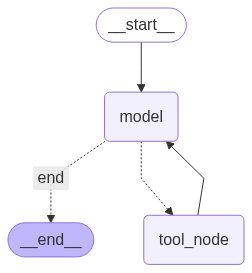

In [8]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [9]:
config = {
    "configurable": {
        "thread_id": 4
    }
}

response = await graph.ainvoke({
    "messages": [HumanMessage(content="When is the next spaceX launch?")], 
}, config=config)

response

{'messages': [HumanMessage(content='When is the next spaceX launch?', additional_kwargs={}, response_metadata={}, id='6cfe4eff-d5be-47f0-ab9a-ea2a4c0ef4c8'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'tavily_search_results_json', 'arguments': '{"query": "next SpaceX launch"}'}}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--dc593f40-5299-4f41-a7bb-8a03225158dd-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'next SpaceX launch'}, 'id': 'fdf722f2-b990-4d68-956f-fc29c9131abd', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 12, 'total_tokens': 69, 'input_token_details': {'cache_read': 0}}),
  ToolMessage(content='[{\'title\': \'SpaceX Launch Schedule - RocketLaunch.org\', \'url\': \'https://rocketlaunch.org/launch-schedule/spacex\', \'content\': \'[All Scheduled Launches](https://rocke

In [ ]:
config = {
    "configurable": {
        "thread_id": 8
    }
}

# Use async for to iterate over the async generator
async for event in graph.astream_events({
    "messages": [HumanMessage(content="When is the next spacex launch?")],
}, config=config, version="v2"):
    print(event)

{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={})]}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'b88a42a9-9519-4a98-a8a8-966ab80bc5c9', 'metadata': {'thread_id': 8}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex launch?', additional_kwargs={}, response_metadata={}, id='b66e2715-09ca-4804-a247-f378dd6cbf3c')]}}, 'name': 'model', 'tags': ['graph:step:1'], 'run_id': '541a95b7-887e-4c72-aafb-81f0dd7aedec', 'metadata': {'thread_id': 8, 'langgraph_step': 1, 'langgraph_node': 'model', 'langgraph_triggers': ('branch:to:model',), 'langgraph_path': ('__pregel_pull', 'model'), 'langgraph_checkpoint_ns': 'model:f8ef3f9e-c43a-aa60-78c4-d55f51f74425'}, 'parent_ids': ['b88a42a9-9519-4a98-a8a8-966ab80bc5c9']}
{'event': 'on_chain_start', 'data': {'input': {'messages': [HumanMessage(content='When is the next spacex la